20211102_S2B3R3E-f_ref


C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


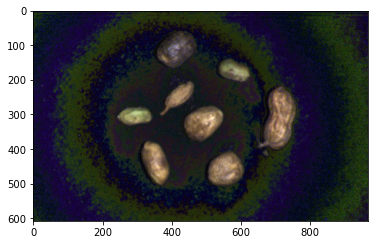

In [1]:
#%%
from scipy.signal import medfilt
from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from PIL import Image
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from skimage import measure
from sklearn.utils import resample
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
from scipy.spatial import distance
from pathlib                 import Path
import glob


plt.close('all')
path = glob.glob(r'./Train_Data/HSI_Data/*')
filename=path[0][path[0].rfind('\\')+1:]
print(filename)
img_rgb = Image.open(os.path.join(path[0], filename+'.png')).convert('RGB')
img_rgb_ar = np.array(img_rgb)
view_rgb = imshow(img_rgb_ar)
hsi_ref = envi.open(os.path.join(path[0], filename+'.hdr'),\
                      os.path.join(path[0], filename+'.dat'))
hsi_np = hsi_ref.asarray()
Mask = np.load('./Train_Data/Valid_Mask/'+filename+'.npy')

In [2]:
#%% filtering the peanut spectra with 1x5 convolutional filter
row,col = np.where(Mask==1)
hsi_p=hsi_np[row,col]
hsi_filtered=np.zeros((len(hsi_p),299))

rand_np = np.copy(hsi_np)
for i in range(len(hsi_p)):
    rand_np[row[i],col[i]] = medfilt(hsi_np[row[i],col[i]],5)

In [3]:
#%% Normalize the peanut spectra
for i in range(len(row)):
    rand_np[row[i],col[i]]=(rand_np[row[i],col[i]]-min(rand_np[row[i],col[i]]))/(max(rand_np[row[i],col[i]])-min(rand_np[row[i],col[i]]))


 
Change in Objective Function Value: inf
Minimum of Maximum Proportions: 0.9999999999999208
Number of Endmembers: 20
Iteration: 1
 
 
Change in Objective Function Value: 54.83448488777094
Minimum of Maximum Proportions: 7.597091044845061e-15
Number of Endmembers: 16
Iteration: 2
 
 
Change in Objective Function Value: 54.41450048450807
Minimum of Maximum Proportions: 7.943890239965149e-15
Number of Endmembers: 12
Iteration: 3
 
 
Change in Objective Function Value: 27.565030927042812
Minimum of Maximum Proportions: 3.244579689451688e-14
Number of Endmembers: 10
Iteration: 4
 
 
Change in Objective Function Value: 13.681132571404532
Minimum of Maximum Proportions: 1.2222951523612457e-14
Number of Endmembers: 9
Iteration: 5
 
 
Change in Objective Function Value: 0.5980532725116063
Minimum of Maximum Proportions: 0.6392906165919462
Number of Endmembers: 9
Iteration: 6
 
 
Change in Objective Function Value: 0.7105060677497761
Minimum of Maximum Proportions: 0.6441108172133254
Number of 

Text(0.5, 1.0, 'SPICE Endmembers')

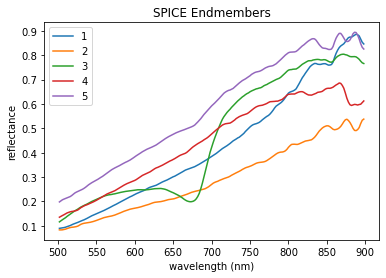

In [4]:
#%%
from Model import *
import matplotlib.pyplot as plt


# def main():

# load the data from the pickle file

valid_mask=Mask.astype(bool)
# trim the noisy bands
hsi_image = rand_np[:,:,50:-50]
x_ax=np.linspace(402,998,299)
x_ax=x_ax[50:-50]
img_shape = hsi_image.shape
n_r, n_c, n_b = hsi_image.shape

# load the wavelength information

# reshape the data because SPICE takes an MxN array, not a full HSI cube
hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
# take the hsi data at the "valid" points
M = hsi_image[valid_array, :]

# since analyzing the image will take a long time, we will down sample the data for the sake of this demo
input_data = M.T.astype(float)
ds_data = input_data[:, ::20] 

# get the default parameters from the SPICE.py file
params = SPICEParameters()
params.qp_solver = 'QPP'
params.gamma=10
params.u=0.1
# run the spice algorithm on the down sampled data
[endmembers, ds_proportions] = SPICE(ds_data, params)

# prompt the user to see if they would like to graph the output
# if input('Would you like to plot the output? (Y/n): ') == 'n':
#     return

# plot the wavelength versus the reflectance
n_em = endmembers.shape[1]
plt.plot(x_ax, endmembers)
plt.xlabel('wavelength (nm)')
plt.ylabel('reflectance')
plt.legend([str(i + 1) for i in range(n_em)])
plt.title('SPICE Endmembers')

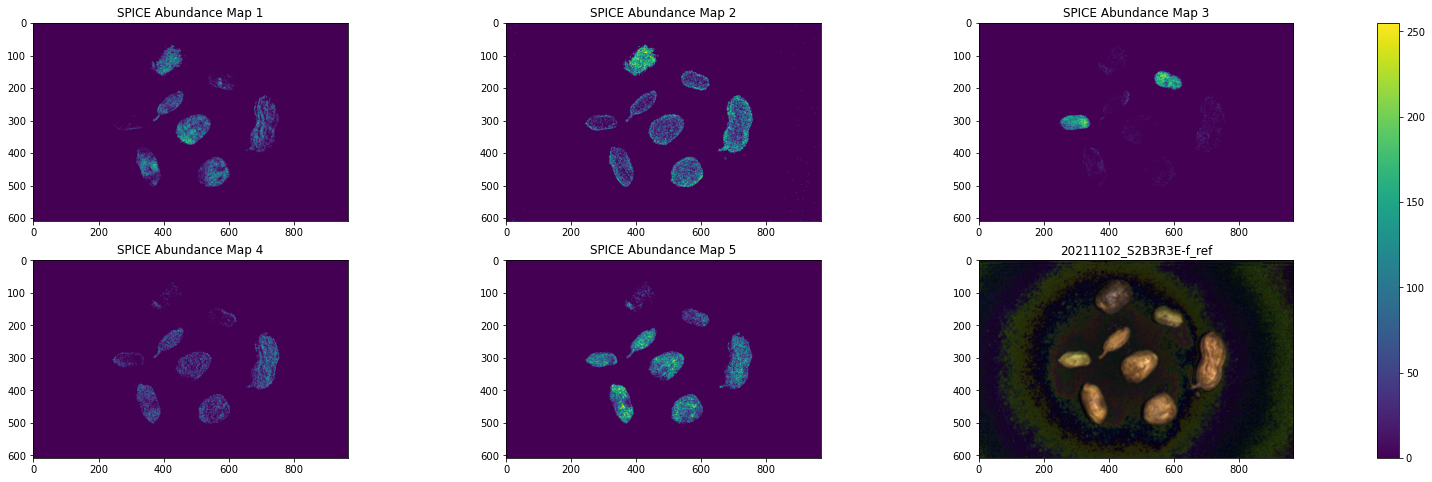

In [5]:
#%%

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 28 10:58:03 2020

@author: weihuang
"""
# load the data from the pickle file

valid_mask=Mask.astype(bool)
# trim the noisy bands
hsi_image = rand_np[:,:,50:-50]
x_ax=np.linspace(402,998,299)
x_ax=x_ax[50:-50]
img_shape = hsi_image.shape
n_r, n_c, n_b = hsi_image.shape

# load the wavelength information

# reshape the data because SPICE takes an MxN array, not a full HSI cube
hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
# take the hsi data at the "valid" points
M = hsi_image[valid_array, :]

# since analyzing the image will take a long time, we will down sample the data for the sake of this demo
input_data = M.T.astype(float)
ds_data = input_data[:, ::20]

# unmix the data using the non-downsampled array and the endmembers that SPICE discovered


if params.qp_solver == 'cvxopt':
    P = unmix_cvxopt(input_data, endmembers)
else:
    scaler = input_data.max()
    P = unmix_qpp(input_data/scaler,endmembers/scaler)

# re-ravel abundance maps
P_imgs = []
for i in range(n_em):
    map_lin = np.zeros((n_r * n_c,))
    map_lin[valid_array] = P[:, i]
    P_imgs.append(np.reshape(map_lin, (n_r, n_c)))

# display abundance maps in the form of a subplot

fig, axes = plt.subplots(2, int(n_em/2) + 1, squeeze=True,figsize=(30,8))

for i in range(n_em):
    im = axes.flat[i].imshow(P_imgs[i], vmin=0, vmax=1)
    axes.flat[i].set_title('SPICE Abundance Map %d' % (i + 1))

# add the original RGB image to the subplot
im = axes.flat[n_em].imshow(img_rgb_ar)
axes.flat[n_em].set_title(filename)
fig.colorbar(im, ax=axes.ravel().tolist())

# delete any empty subplots
if (n_em % 2 == 0):
    fig.delaxes(axes.flatten()[(2*(int(n_em/2)+1)) -1])
# plt.savefig(filename+'.jpg')
plt.show()
    

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


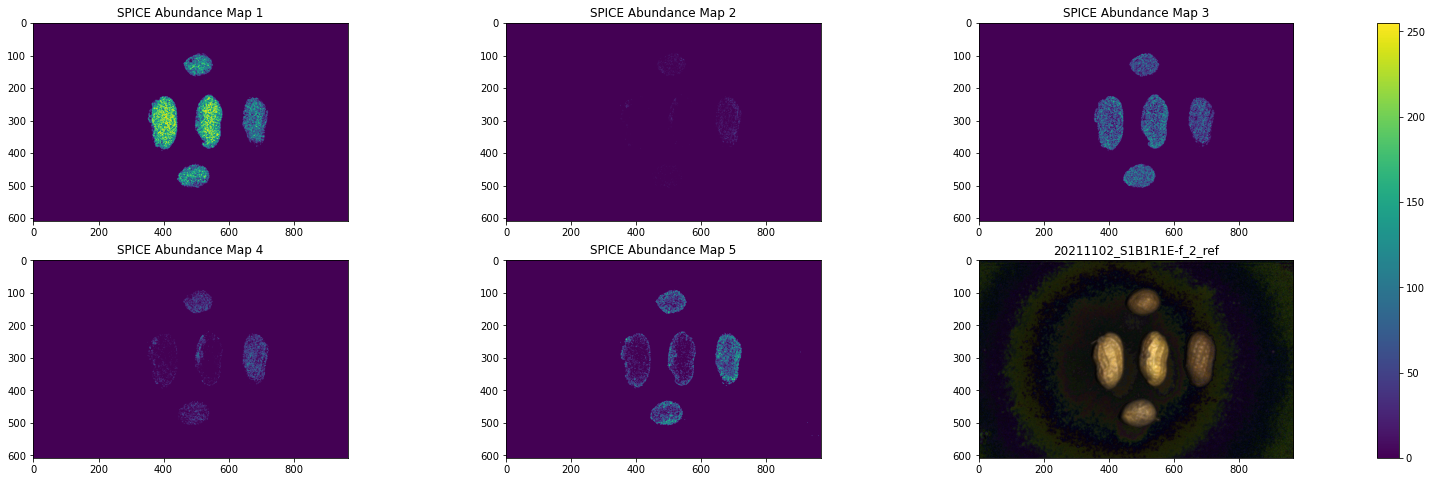

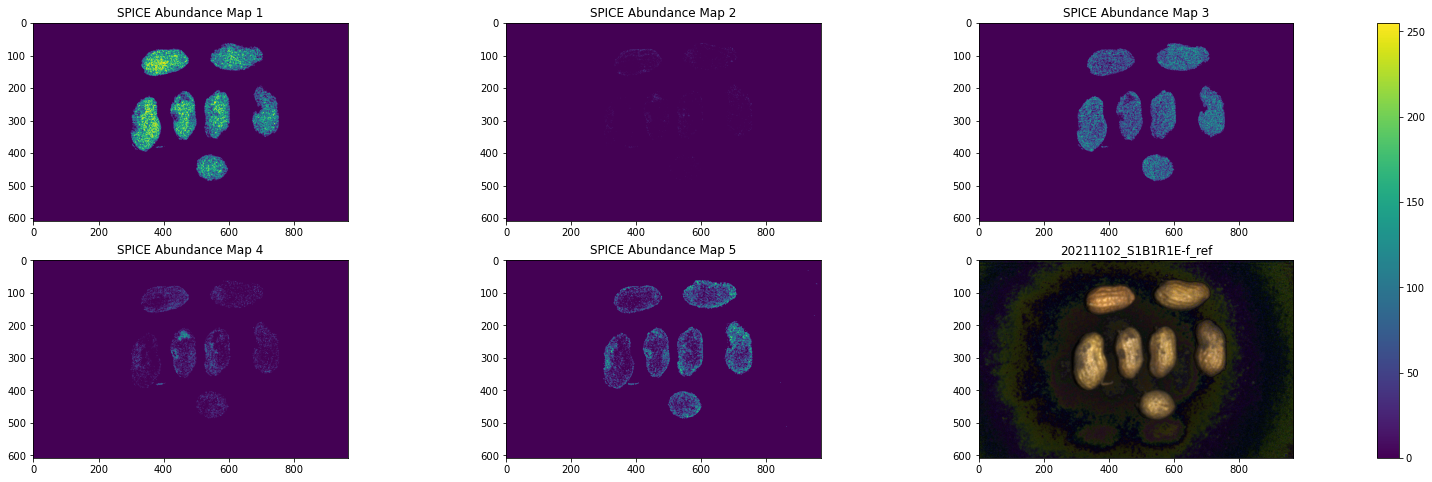

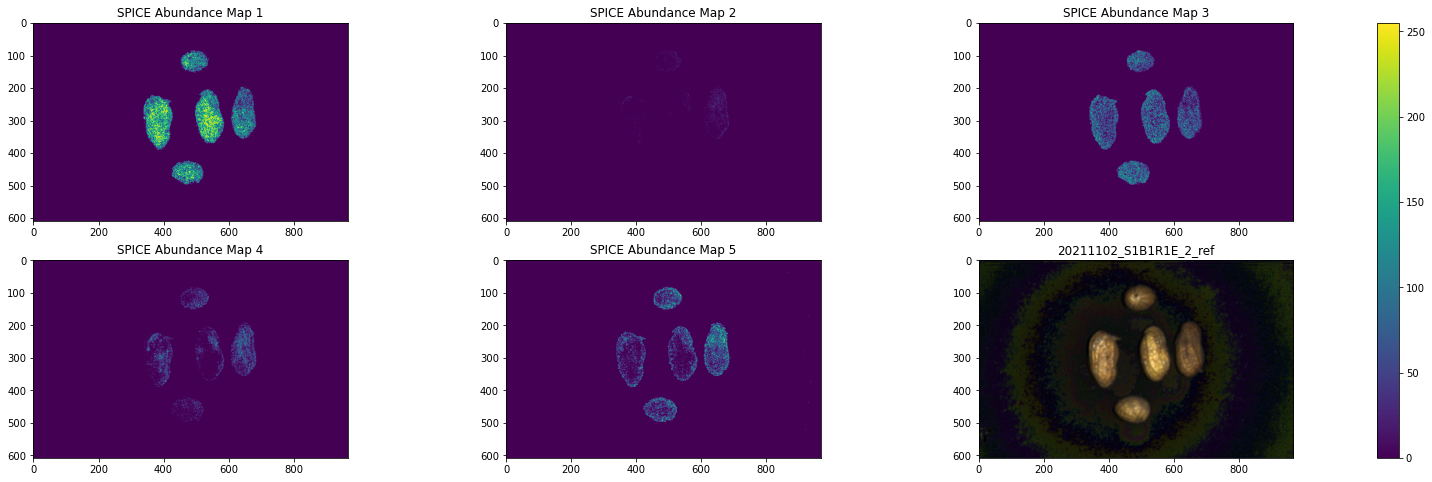

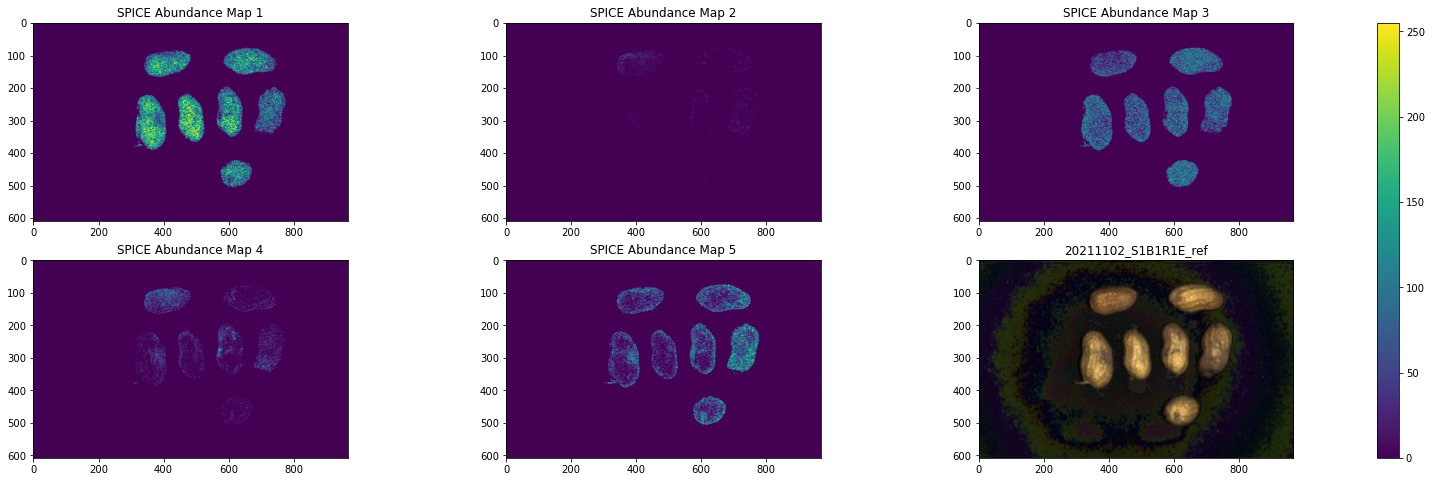

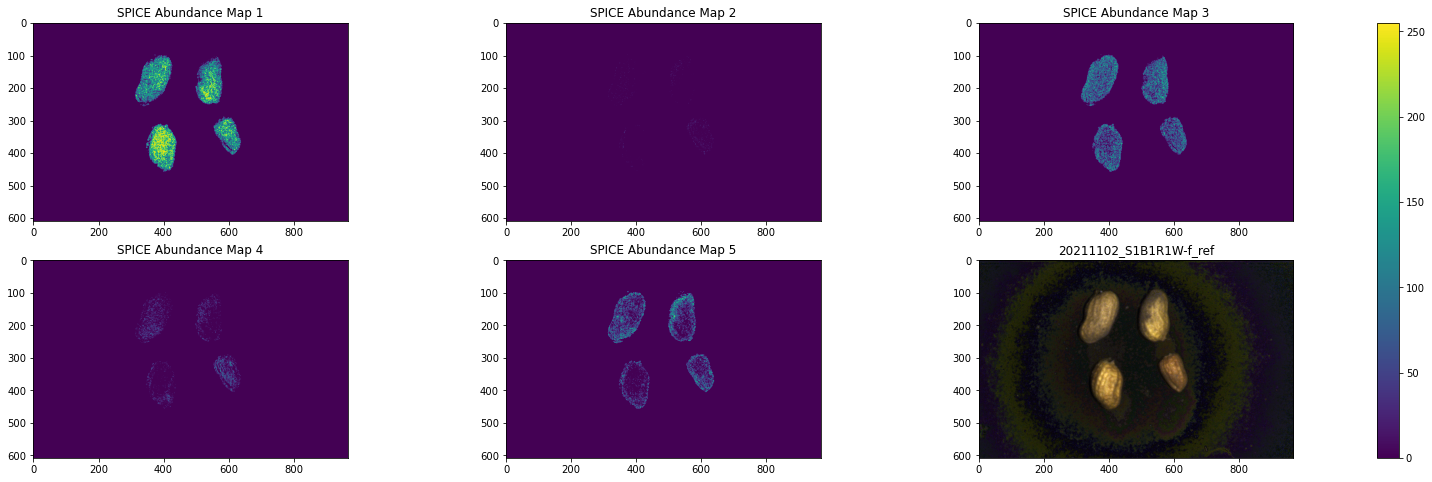

In [9]:
# testing images on the endmembers
plt.close('all')
label_path='U:\AT\Data\lab_HSI\Greenhouse_202111\Masks' #path to your .npy masks
v=glob.glob('U:\AT\Data\lab_HSI\Greenhouse_202111\Reflectance folders\*') # path to your HSI Data that needs unmixing based on the EMs you found. The path should be to the folders that has
                                                                          # both .hdr and .dat files
count=1                                                                
num_of_imgs=6 # Specify the number of images you want to see being unmixed from your test data                                                                          
for i in v:
    if(count==num_of_imgs):
        break
    filename=i[i.rfind('\\')+1:]
    path='U:\AT\Data\lab_HSI\Greenhouse_202111\Reflectance folders\\'+i[i.rfind('\\')+1:]
    img_rgb = Image.open(os.path.join(path, filename+'.png')).convert('RGB')
    img_rgb_ar = np.array(img_rgb)
    # view_rgb = imshow(img_rgb_ar)
    hsi_ref = envi.open(os.path.join(path, filename+'.hdr'),\
                        os.path.join(path, filename+'.dat'))
    hsi_np = hsi_ref.asarray()
    test_lab = np.load(os.path.join(label_path,filename+'.npy'))
    # filtering the original peanut spectra using a 1X5 convolutional vector (median filtger).
    row,col = np.where(test_lab==1)
    hsi_p=hsi_np[row,col]
    hsi_filtered=np.zeros((len(hsi_p),299))
    rand_np = np.copy(hsi_np)
    for i in range(len(hsi_p)):
        rand_np[row[i],col[i]] = medfilt(hsi_np[row[i],col[i]],5)
    # Normalize the peanut spectra using min-max normalization
    for i in range(len(row)):
        rand_np[row[i],col[i]]=(rand_np[row[i],col[i]]-min(rand_np[row[i],col[i]]))/(max(rand_np[row[i],col[i]])-min(rand_np[row[i],col[i]]))
    # change your mask variable to bool type
    valid_mask=test_lab.astype(bool)
    # trim the noisy bands
    hsi_image = rand_np[:,:,50:-50]
    img_shape = hsi_image.shape
    n_r, n_c, n_b = hsi_image.shape
    # reshape the data because SPICE takes an MxN array, not a full HSI cube
    hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
    valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
    # take the hsi data at the "valid" points
    M = hsi_image[valid_array, :]
    # since analyzing the image will take a long time, we will down sample the data for the sake of this demo
    input_data = M.T.astype(float)
    ds_data = input_data[:, ::20]
    # unmix the data using the non-downsampled array and the endmembers that SPICE discovered
    if params.qp_solver == 'cvxopt':
        P = unmix_cvxopt(input_data, endmembers)
    else:
        scaler = input_data.max()
        P = unmix_qpp(input_data/scaler,endmembers/scaler)
    # re-ravel abundance maps
    P_imgs = []
    for i in range(n_em):
        map_lin = np.zeros((n_r * n_c,))
        map_lin[valid_array] = P[:, i]
        P_imgs.append(np.reshape(map_lin, (n_r, n_c)))
    # display abundance maps in the form of a subplot
    fig, axes = plt.subplots(2, int(n_em/2) + 1, squeeze=True,figsize=(30,8))
    for i in range(n_em):
        im = axes.flat[i].imshow(P_imgs[i], vmin=0, vmax=1)
        axes.flat[i].set_title('SPICE Abundance Map %d' % (i + 1))
    # add the original RGB image to the subplot
    im = axes.flat[n_em].imshow(img_rgb_ar)
    axes.flat[n_em].set_title(filename)
    fig.colorbar(im, ax=axes.ravel().tolist())
    # delete any empty subplots
    if (n_em % 2 == 0):
        fig.delaxes(axes.flatten()[(2*(int(n_em/2)+1)) -1])
    # plt.savefig(filename+'.jpg')
    plt.show()
    count+=1